In [623]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
import warnings
warnings.filterwarnings('ignore')

In [624]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [625]:
forecast_weather = pd.read_csv('../../Data\\capstone\\weather/solar_forecast_weather.csv')
solar = pd.read_csv('../../Data\\capstone\\weather/solar_power_2204.csv')
real_weather = pd.read_csv('../../Data/capstone/total_eda_real.csv')
solar_2 = pd.read_csv('../../Data/capstone/발전소/하동_eda.csv')

In [626]:
def time_change(data, Forecast_time):
    """
    data = forecast가 있는 데이터
    Forecast_time = 예보시간

    return = 예보시간을 기준으로 데이터를 정렬한 데이터
    """
    data[Forecast_time] = pd.to_datetime(data[Forecast_time])
    data['real_time'] = data.apply(lambda row: row['Forecast time'] + datetime.timedelta(hours=row['forecast']), axis=1)
    forecast_weather_eda = data.groupby(['real_time']).mean().drop('forecast', axis=1)
    forecast_weather_eda.reset_index(inplace=True)
    return forecast_weather_eda

In [627]:
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar.target.replace(65535.0, solar.target.mean(), inplace=True)
solar['month'] = solar.datetime.dt.month
solar['hour'] = solar.datetime.dt.hour
solar['year'] = solar.datetime.dt.year
solar['day'] = solar.datetime.dt.day
solar_eda = solar.groupby(['year','month','day','hour']).sum().reset_index()
solar_eda['date'] = pd.to_datetime(solar_eda[['year', 'month', 'day', 'hour']])

In [628]:
eda_forecast = time_change(forecast_weather, 'Forecast time')

In [629]:
real_weather[real_weather['지점명']=='구미']

,지점,위도,경도,지점명,일시,기온,풍속,풍향,습도,강수량
1504656,279,36.1306,128.3206,구미,2021-01-01 00:00,-4.3,1.9,290.0,61.0,0.0
1504657,279,36.1306,128.3206,구미,2021-01-01 01:00,-4.8,0.5,320.0,64.0,0.0
1504658,279,36.1306,128.3206,구미,2021-01-01 02:00,-5.4,1.6,320.0,69.0,0.0
1504659,279,36.1306,128.3206,구미,2021-01-01 03:00,-4.4,1.8,290.0,68.0,0.0
1504660,279,36.1306,128.3206,구미,2021-01-01 04:00,-4.9,1.3,290.0,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1522147,279,36.1306,128.3206,구미,2022-12-30 20:00,-0.3,0.0,0.0,65.0,0.0
1522148,279,36.1306,128.3206,구미,2022-12-30 21:00,-1.0,0.0,0.0,67.0,0.0
1522149,279,36.1306,128.3206,구미,2022-12-30 22:00,-1.0,0.0,0.0,67.0,0.0
1522150,279,36.1306,128.3206,구미,2022-12-30 23:00,-0.4,0.1,0.0,63.0,0.0


In [630]:
real_weather[real_weather['지점명'] =='순천']

,지점,위도,경도,지점명,일시,기온,풍속,풍향,습도,강수량
682344,174,35.0204,127.3694,순천,2021-01-01 00:00,-2.3,3.8,290.0,81.0,0.0
682345,174,35.0204,127.3694,순천,2021-01-01 01:00,-3.1,3.3,290.0,71.0,0.0
682346,174,35.0204,127.3694,순천,2021-01-01 02:00,-3.7,3.6,290.0,73.0,0.0
682347,174,35.0204,127.3694,순천,2021-01-01 03:00,-4.2,3.1,270.0,76.0,0.0
682348,174,35.0204,127.3694,순천,2021-01-01 04:00,-4.2,2.4,270.0,76.0,0.0
...,...,...,...,...,...,...,...,...,...,...
699835,174,35.0204,127.3694,순천,2022-12-30 20:00,1.0,1.8,320.0,68.0,0.0
699836,174,35.0204,127.3694,순천,2022-12-30 21:00,-0.3,2.9,270.0,73.0,0.0
699837,174,35.0204,127.3694,순천,2022-12-30 22:00,0.3,2.3,290.0,72.0,0.0
699838,174,35.0204,127.3694,순천,2022-12-30 23:00,0.4,2.7,270.0,74.0,0.0


In [631]:
incheon = real_weather[real_weather['지점명'] =='순천']

In [632]:
eda_weather = incheon.drop(['지점', '지점명'], axis=1)
eda_weather['일시'] = pd.to_datetime(eda_weather['일시'])
eda_weather['hour'] = eda_weather['일시'].dt.hour
eda_weather['month'] = eda_weather['일시'].dt.month
eda_weather['year'] = eda_weather['일시'].dt.year

In [633]:
eda_weather.set_index('일시', inplace=True)

In [634]:
total_time = pd.date_range(start='2021-01-01 00:00:00', end='2022-04-30 23:00:00', freq='H')

In [635]:
solar_2

,date,hour,value
0,2013-01-01 01:00:00,1,0.0
1,2013-01-01 02:00:00,2,0.0
2,2013-01-01 03:00:00,3,0.0
3,2013-01-01 04:00:00,4,0.0
4,2013-01-01 05:00:00,5,0.0
...,...,...,...
83227,2022-06-30 20:00:00,20,7.6
83228,2022-06-30 21:00:00,21,0.0
83229,2022-06-30 22:00:00,22,0.0
83230,2022-06-30 23:00:00,23,0.0


In [636]:
solar_2.date = pd.to_datetime(solar_2.date)

In [637]:
solar_2.set_index('date', inplace=True)

In [638]:
x = eda_weather.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [639]:
x

,위도,경도,기온,풍속,풍향,습도,강수량,hour,month,year
일시,,,,,,,,,,
2021-01-01 00:00:00,35.0204,127.3694,-2.3,3.8,290.0,81.0,0.0,0,1,2021
2021-01-01 01:00:00,35.0204,127.3694,-3.1,3.3,290.0,71.0,0.0,1,1,2021
2021-01-01 02:00:00,35.0204,127.3694,-3.7,3.6,290.0,73.0,0.0,2,1,2021
2021-01-01 03:00:00,35.0204,127.3694,-4.2,3.1,270.0,76.0,0.0,3,1,2021
2021-01-01 04:00:00,35.0204,127.3694,-4.2,2.4,270.0,76.0,0.0,4,1,2021
...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,35.0204,127.3694,13.9,3.0,290.0,70.0,0.0,19,4,2022
2022-04-30 20:00:00,35.0204,127.3694,12.9,2.2,290.0,78.0,0.0,20,4,2022
2022-04-30 21:00:00,35.0204,127.3694,12.5,2.5,290.0,78.0,0.0,21,4,2022


In [640]:
solar_2

,hour,value
date,,
2013-01-01 01:00:00,1,0.0
2013-01-01 02:00:00,2,0.0
2013-01-01 03:00:00,3,0.0
2013-01-01 04:00:00,4,0.0
2013-01-01 05:00:00,5,0.0
...,...,...
2022-06-30 20:00:00,20,7.6
2022-06-30 21:00:00,21,0.0
2022-06-30 22:00:00,22,0.0


In [641]:
y = solar_2.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

x.drop(['위도','경도'], axis=1, inplace=True)

In [642]:
total = pd.concat([x, y], axis = 1)

In [643]:
total.interpolate(method = 'linear', inplace = True)

In [644]:
y = total.value / 5
x = total.drop('value', axis=1)

In [645]:
slice = 455 * 24

In [646]:
x_train = x.iloc[:slice]
x_test = x.iloc[slice:]
y_train = y.iloc[:slice]
y_test = y.iloc[slice:]

In [647]:
sc_x = StandardScaler()
sc_y = StandardScaler()

In [648]:
sc_x.fit(x_train)

x_train = sc_x.transform(x_train)
x_test = sc_x.transform(x_test)

In [649]:
sc_y.fit(y_train.values.reshape(-1,1))

y_train = sc_y.transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()

In [650]:
print(x_train.shape)
print(x_test.shape)

(10920, 11)
(720, 11)


In [651]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [652]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [653]:
dt = DecisionTreeRegressor(max_depth=5)

In [654]:
params = {
    'n_estimators' : [5,10,50,100],
    'max_depth': [2,5,6,8,10],
    'min_samples_leaf':[4,8,12,16],
    'min_samples_split':[4,8,16,20,24]
}

In [655]:
lg_params = {
    'n_estimators' : [5,10,50,100],
    'max_depth': [2,5,6,8,10, -1],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves' : [16, 32, 64, 128, 256],
    'verbose': [-1]
}

In [656]:
rf = RandomForestRegressor(n_jobs = -1)
et = ExtraTreesRegressor(n_jobs = -1)
lg = LGBMRegressor(n_jobs = -1)

In [657]:
grid_cv_rf = GridSearchCV(rf, param_grid=params,
                      cv=5, n_jobs=-1)
grid_cv_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 6, 8, 10],
                         'min_samples_leaf': [4, 8, 12, 16],
                         'min_samples_split': [4, 8, 16, 20, 24],
                         'n_estimators': [5, 10, 50, 100]})

In [658]:
grid_cv_et = GridSearchCV(et, param_grid=params,
                      cv=5, n_jobs=-1)
grid_cv_et.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 6, 8, 10],
                         'min_samples_leaf': [4, 8, 12, 16],
                         'min_samples_split': [4, 8, 16, 20, 24],
                         'n_estimators': [5, 10, 50, 100]})

In [659]:
grid_cv_lg = GridSearchCV(lg, param_grid=lg_params,
                      cv=5, n_jobs=-1)
grid_cv_lg.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 5, 6, 8, 10, -1],
                         'n_estimators': [5, 10, 50, 100],
                         'num_leaves': [16, 32, 64, 128, 256],
                         'verbose': [-1]})

In [660]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.001)

In [661]:
# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(11, 1), return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(24))
lstm_model.compile(loss='mse', optimizer = optimizer, metrics=['mse'])

In [662]:
window_size = 24 * 365

In [663]:
from tqdm import tqdm

In [664]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

Epoch 1/240
365/365 [==============================] - 5s 8ms/step - loss: 0.6973 - mse: 0.6973
Epoch 2/240
365/365 [==============================] - 3s 8ms/step - loss: 0.5536 - mse: 0.5536
Epoch 3/240
365/365 [==============================] - 3s 8ms/step - loss: 0.4639 - mse: 0.4639
Epoch 4/240
365/365 [==============================] - 3s 8ms/step - loss: 0.3528 - mse: 0.3528
Epoch 5/240
365/365 [==============================] - 3s 8ms/step - loss: 0.2237 - mse: 0.2237
Epoch 6/240
365/365 [==============================] - 3s 8ms/step - loss: 0.1692 - mse: 0.1692
Epoch 7/240
365/365 [==============================] - 3s 8ms/step - loss: 0.1527 - mse: 0.1527
Epoch 8/240
365/365 [==============================] - 3s 8ms/step - loss: 0.1439 - mse: 0.1439
Epoch 9/240
365/365 [==============================] - 3s 8ms/step - loss: 0.1381 - mse: 0.1381
Epoch 10/240
365/365 [==============================] - 3s 8ms/step - loss: 0.1338 - mse: 0.1338
Epoch 11/240
365/365 [=================

In [665]:
predictions_list = []

for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24]
    y_test_window = y_test[i:i+24]

    predictions_rf = grid_cv_rf.best_estimator_.predict(x_test_window)
    predictions_et = grid_cv_et.best_estimator_.predict(x_test_window)
    predictions_lg = grid_cv_lg.best_estimator_.predict(x_test_window)
    predictions_lstm = lstm_model.predict(x_test_window)

    for j in range(24):
        predictions_list.append([predictions_rf[j], predictions_et[j], predictions_lg[j], predictions_lstm[0][j]])

    x_train = np.concatenate((x_train, x_test_window), axis=0)
    y_train = np.concatenate((y_train, y_test_window), axis=0)

    grid_cv_rf.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train[i+24:i+24+window_size])
    grid_cv_et.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train[i+24:i+24+window_size])
    grid_cv_lg.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train[i+24:i+24+window_size])
    lstm_model.fit(x_train[i+24:i+24+window_size].reshape(-1,11,1), y_train[i+24:i+24+window_size], epochs=240, verbose=0, batch_size=24)

predictions_array = np.array(predictions_list)

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 419ms/step


  3%|▎         | 1/30 [11:23<5:30:26, 683.67s/it]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 2/30 [22:48<5:19:24, 684.44s/it]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 3/30 [34:26<5:10:43, 690.52s/it]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 4/30 [45:59<4:59:43, 691.67s/it]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 5/30 [57:24<4:47:11, 689.24s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 6/30 [1:09:21<4:39:23, 698.48s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 7/30 [1:21:00<4:27:53, 698.84s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 8/30 [1:32:21<4:14:09, 693.14s/it]

1/1 [==============================] - 0s 18ms/step


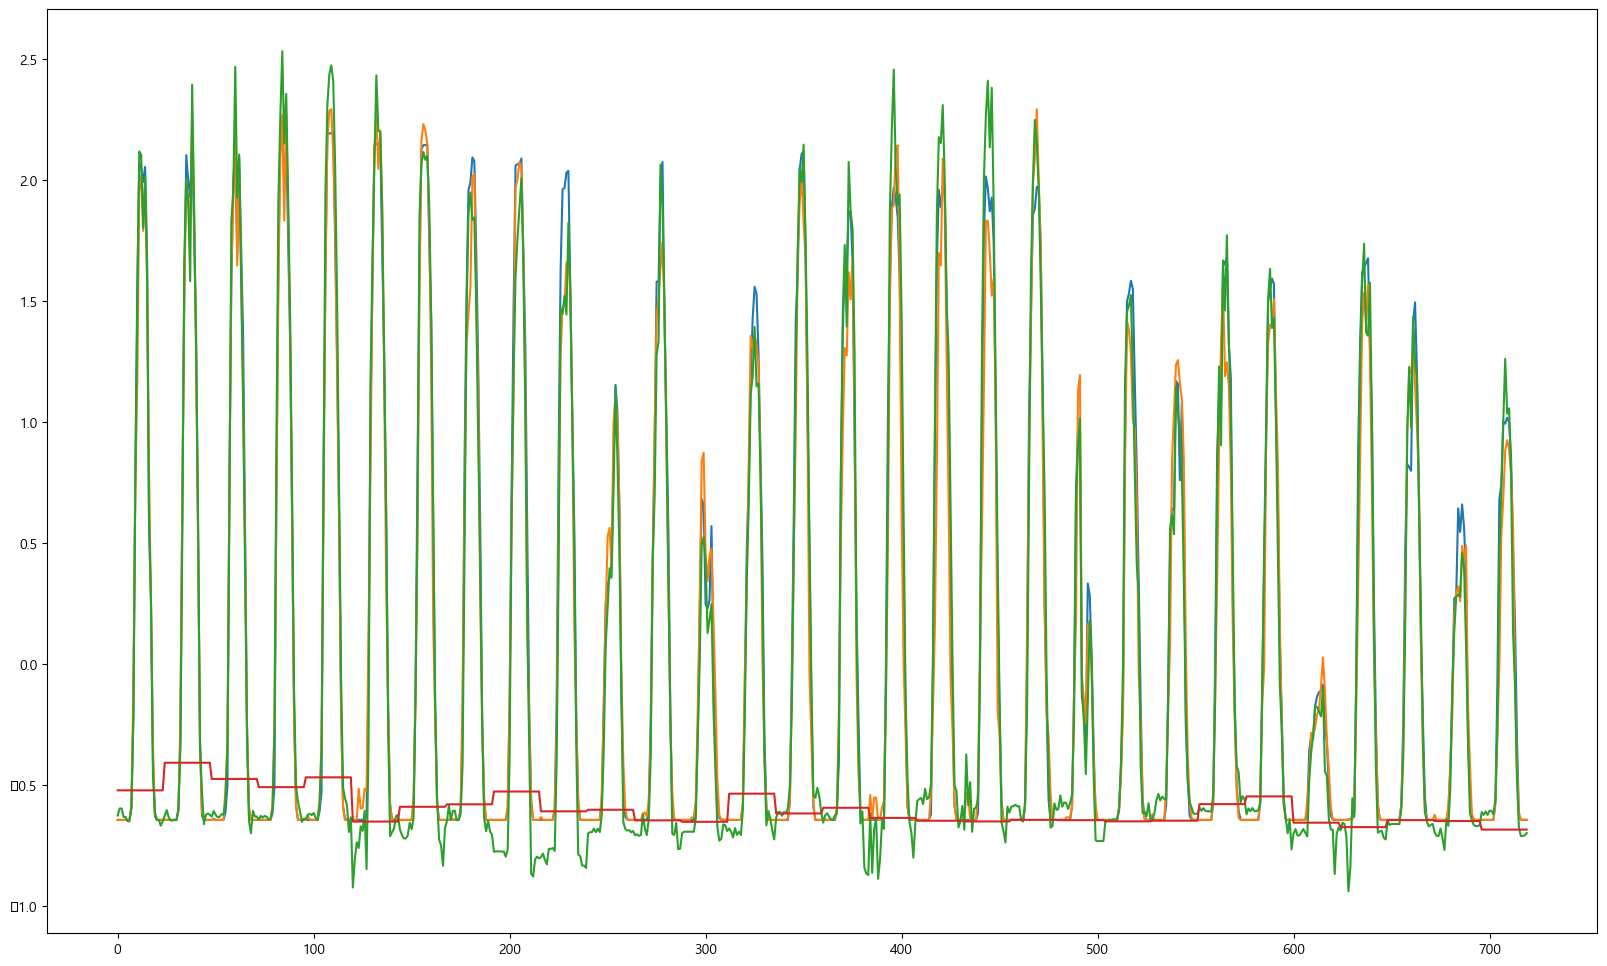

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(predictions_list)

lstm_model.fit(x_train[:window_size].reshape(-1, 8, 1), y_train[:window_size], epochs=100, verbose=0)

lstm_predictions_list = []

# 테스트 데이터를 24시간 단위로 이동하면서 예측
for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24].values.reshape(-1, 8, 1)
    y_test_window = y_test[i:i+24]

    predictions_lstm = lstm_model.predict(x_test_window)
    
    # 각 샘플에 대한 예측을 저장
    for j in range(24):
        lstm_predictions_list.append(predictions_lstm[j])

    # 새로운 24시간 데이터를 훈련 데이터에 추가
    x_train = np.concatenate((x_train, x_test_window.reshape(-1, 8)), axis=0)
    y_train = np.concatenate((y_train, y_test_window), axis=0)

    # 새로운 윈도우 크기로 훈련
    lstm_model.fit(x_train[i+24:i+24+window_size].reshape(-1, 8, 1), y_train[i+24:i+24+window_size], epochs=100, verbose=0)

lstm_predictions_array = np.array(lstm_predictions_list)

lstm_predictions_array.shape

plt.plot(lstm_predictions_array.reshape(-1,1)) 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_et.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
lstm_model.fit(x_train[:window_size].reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24)

Epoch 1/240
365/365 [==============================] - 3s 7ms/step - loss: 0.0070 - mse: 0.0070
Epoch 2/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0038 - mse: 0.0038
Epoch 3/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0022 - mse: 0.0022
Epoch 4/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0016 - mse: 0.0016
Epoch 5/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0015 - mse: 0.0015
Epoch 6/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0013 - mse: 0.0013
Epoch 7/240
365/365 [==============================] - 3s 8ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/240
365/365 [==============================] - 3s 8ms/step - loss: 8.8908e-04 - mse: 8.8908e-04
Epoch 9/240
365/365 [==============================] - 3s 8ms/step - loss: 6.2223e-04 - mse: 6.2223e-04
Epoch 10/240
365/365 [==============================] - 3s 8ms/step - loss: 5.8126e-04 - mse: 5.8126e-04
Epoch 11/240
36

In [ ]:
train_predictions_list = []

# 훈련 데이터에 대한 예측 수집
for i in range(0, len(x_train), 24):
    x_train_window = x_train[i:i+window_size]

    train_predictions_rf = grid_cv_rf.best_estimator_.predict(x_train_window)
    train_predictions_et = grid_cv_et.best_estimator_.predict(x_train_window)
    train_predictions_lg = grid_cv_lg.best_estimator_.predict(x_train_window)
    train_predictions_lstm = lstm_model.predict(x_train_window)

    for j in range(24):
        train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_lg[j], train_predictions_lstm[0][j]])

1/1 [==============================] - 0s 17ms/step


In [ ]:
train_predictions_array = np.array(train_predictions_list)

In [ ]:
meta_model = LinearRegression()

In [ ]:
meta_model.fit(train_predictions_array, y_train[:len(train_predictions_array)])

LinearRegression()

In [ ]:
meta_model.coef_

array([  4.94058101,   1.37889195,  13.99019381, 162.93412648])

In [ ]:
meta_result = meta_model.predict(predictions_array)

In [ ]:
predictions_array

array([[-0.64253678, -0.64253851, -0.62422013, -0.52040684],
       [-0.64253851, -0.64253851, -0.59534537, -0.52040672],
       [-0.64253851, -0.64253851, -0.59534537, -0.52040696],
       ...,
       [-0.64253755, -0.64248012, -0.70931461, -0.68250012],
       [-0.64253082, -0.64249028, -0.70615282, -0.68250024],
       [-0.64253082, -0.64249028, -0.69647434, -0.68250024]])

meta_result = meta_model.predict(np.nan_to_num(predictions_array, nan = 0))

In [ ]:
meta_result_change = np.maximum(meta_result, 0)

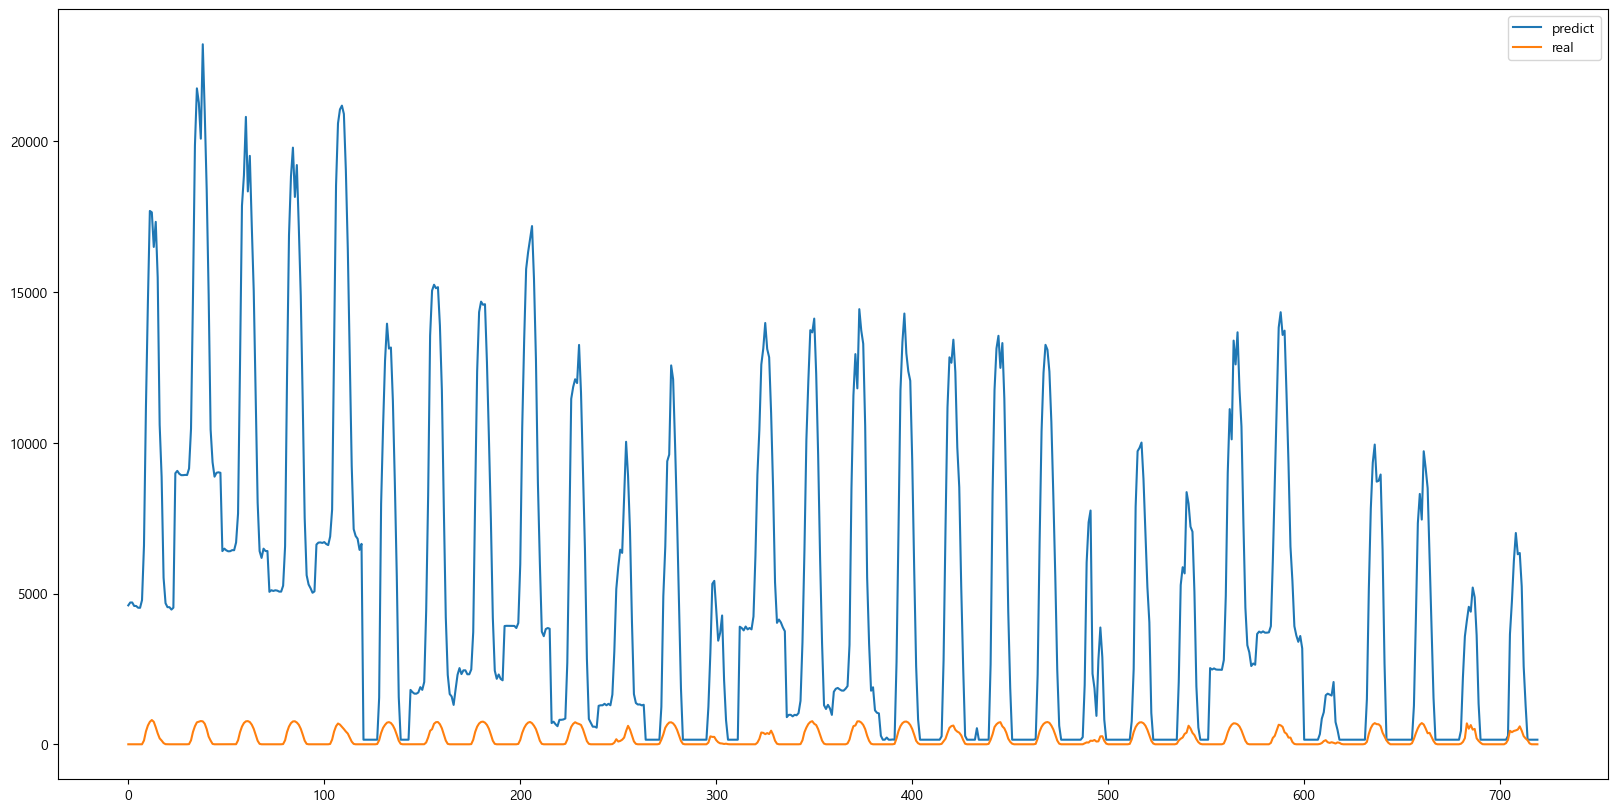

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(meta_result_change.reshape(-1,1)), label='predict')
plt.plot(np.arange(len(meta_result)), y_test, label='real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_error(sc.inverse_transform()), sc.inverse_transform(np.ravel(y_test))

In [ ]:
mean_absolute_error(np.maximum(sc.inverse_transform(meta_result),0), sc.inverse_transform(y_test))

48.85020403522994

In [ ]:
mean_absolute_percentage_error(np.maximum(sc.inverse_transform(meta_result),0), sc.inverse_transform(y_test))

2602580184661550.0

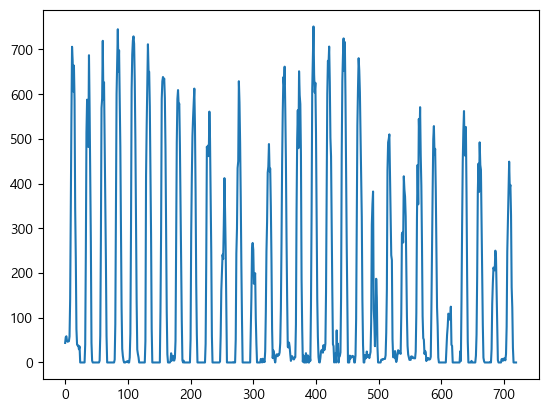

In [ ]:
plt.plot(np.maximum(sc.inverse_transform(meta_result),0))

In [ ]:
sc.inverse_transform(y_test)

array([[0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [1.2576e+02],
       [4.2664e+02],
       [6.2272e+02],
       [7.4456e+02],
       [8.0432e+02],
       [7.4488e+02],
       [5.6400e+02],
       [3.6104e+02],
       [1.9632e+02],
       [1.2416e+02],
       [4.0160e+01],
       [3.4400e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [5.6800e+00],
       [1.3072e+02],
       [4.1024e+02],
       [5.9928e+02],
       [7.2744e+02],
       [7.5040e+02],
       [7.7056e+02],
       [7.6064e+02],
       [6.8280e+02],
       [5.0440e+02],
       [2.5480e+02],
       [1.2280e+02],
       [1.2240e+01],
       [0.0000e+00],
       [0.0000e+00],
       [0.0000e+00],
       [0.000

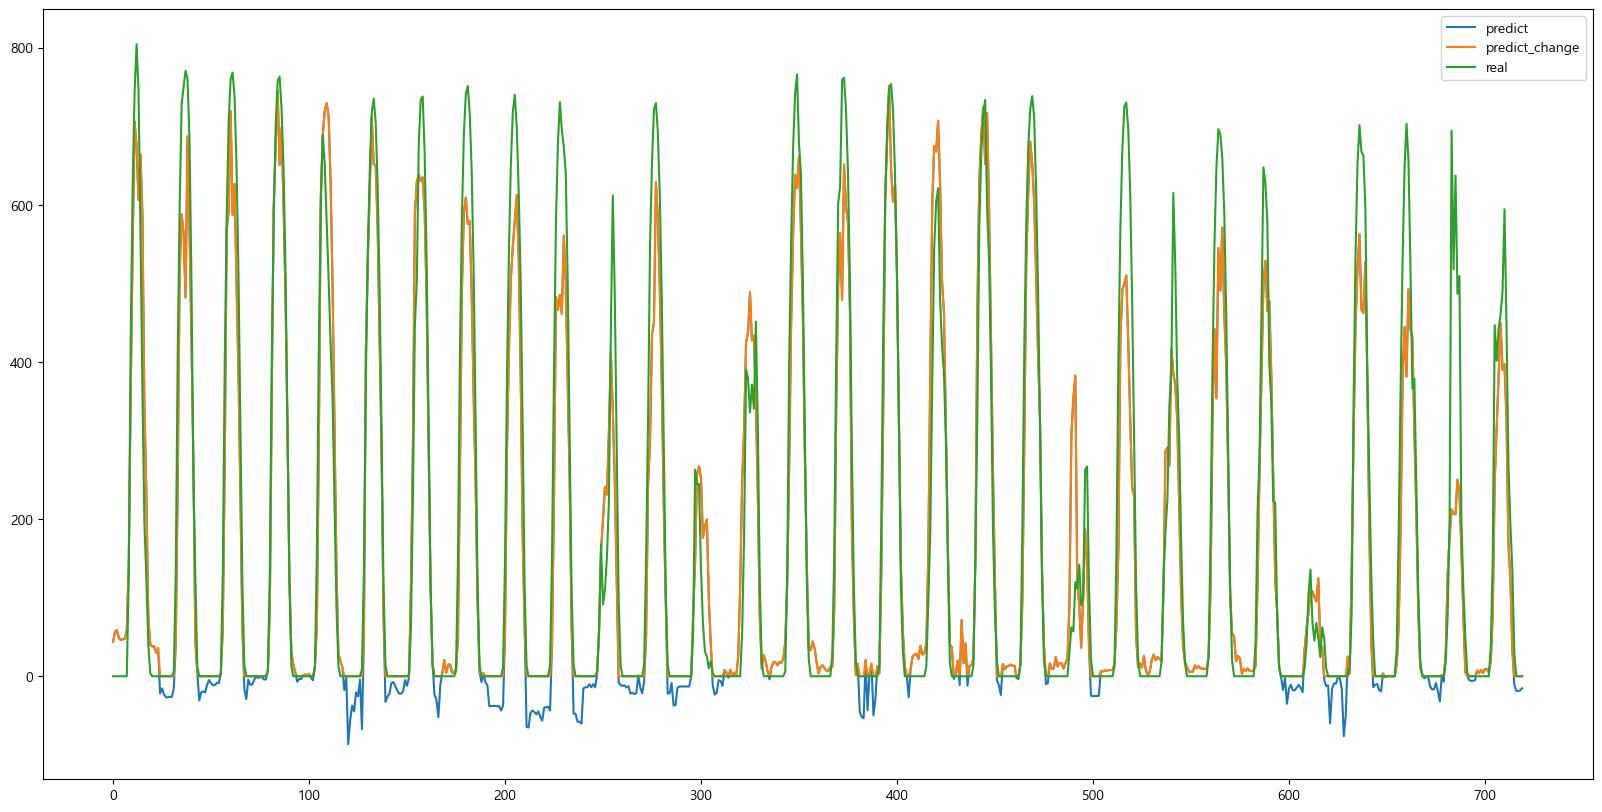

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(meta_result)), sc.inverse_transform(meta_result), label='predict')
plt.plot(np.arange(len(meta_result)), np.maximum(sc.inverse_transform(meta_result),0), label='predict_change')
plt.plot(np.arange(len(meta_result)), sc.inverse_transform(y_test), label='real')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(y_test, meta_result)

0.12872310035320145

In [ ]:
mean_absolute_error(y_test, meta_result)

0.23155001533017117

In [ ]:
mean_absolute_error(y_test[:24], meta_result[:24])

0.29398967466884796

In [ ]:
predictions_array

array([[-0.64253831, -0.63787629, -0.63930858, -0.00796111],
       [-0.64253851, -0.64253851, -0.59273037,  0.00222468],
       [-0.64253851, -0.64253851, -0.58588635,  0.00274874],
       ...,
       [-0.64253709, -0.64246669, -0.70931461, -0.64792466],
       [-0.64253709, -0.64253066, -0.70615282, -0.64792466],
       [-0.64253709, -0.64253851, -0.69647434, -0.64792472]])

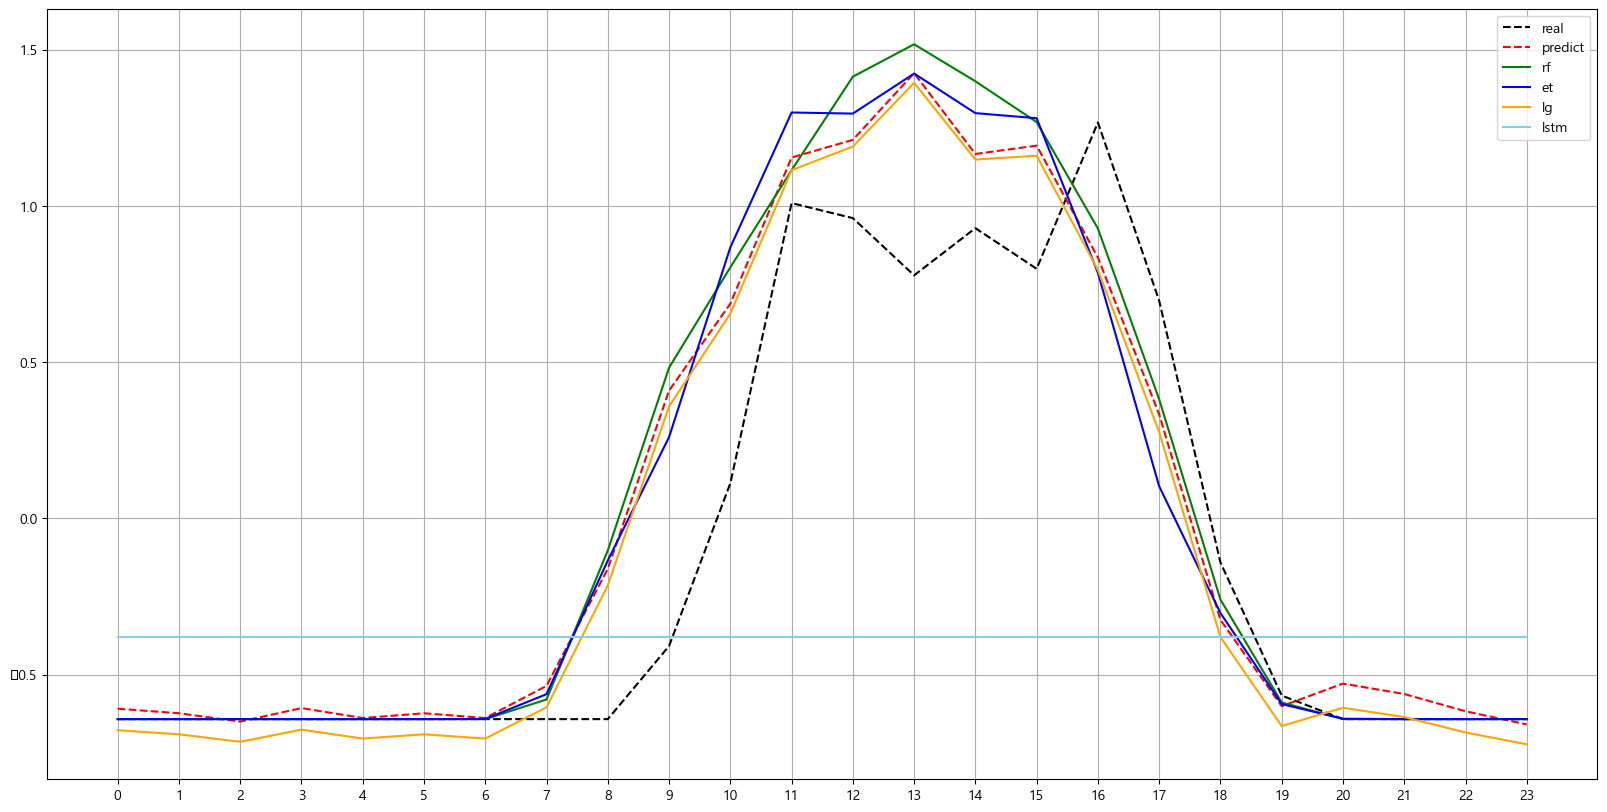

0.2093699485490389

In [ ]:
i = 13
plt.figure(figsize=(20,10))
plt.plot(np.arange(24), y_test[i * 24 : 24*(i+1)], 'k--')
plt.plot(np.arange(24), meta_result[i * 24 : 24*(i+1)], 'r--')

plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),0], color = 'green')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),1], color = 'blue')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),2], color = 'orange')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),3], color = 'skyblue')
plt.legend(['real','predict', 'rf', 'et', 'lg', 'lstm'])
plt.xticks(np.arange(24))
plt.grid()
plt.show()

mean_absolute_error(y_test[i * 24 : 24*(i+1)], meta_result[i * 24 : 24*(i+1)])

# MAP